## 賃料についてのドメイン知識


- https://lobotomy-project.org/marketpricerent/
- https://ameblo.jp/enjoytokyolovelivelife/entry-11084920720.html


In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
from scipy.stats import norm, skew
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import matplotlib
font = {'family': 'Yu Mincho'}
matplotlib.rc('font', **font)

pd.set_option('max_columns',1000)
pd.set_option('max_rows',1000)

import warnings
warnings.filterwarnings('ignore')

import re
import geocoder
from geopy.distance import great_circle, vincenty
from tqdm import tqdm

import os
import gc
print(os.listdir("../../input"))
print(os.listdir("../../submit"))

SEED=1234
n_splits=10

['data', 'hyokasho-2019', 'line.csv', 'location 保存用.txt', 'location.csv', 'location.txt', 'manshon.csv', 'other', 'station.csv', 'station.txt', 'station2.txt', 'test.csv', 'test.pkl', 'tokyo23', 'train.csv', 'train.pkl', '駅マンション平均単価.xlsx']
['feature.csv', 'sample_submit.csv', 'submit1.csv', 'submit10.csv', 'submit11.csv', 'submit12.csv', 'submit13.csv', 'submit14.csv', 'submit15.csv', 'submit16.csv', 'submit17.csv', 'submit18.csv', 'submit19.csv', 'submit2.csv', 'submit20.csv', 'submit21.csv', 'submit22.csv', 'submit23.csv', 'submit24.csv', 'submit25.csv', 'submit26.csv', 'submit28.csv', 'submit3.csv', 'submit4.csv', 'submit5.csv', 'submit6.csv', 'submit7.csv', 'submit8.csv', 'submit9.csv', '特徴量について.xlsx']


### 所在地

In [2]:
def get_location_lonlat(df):
    '''
    緯度経度取得関数
    '''
    loc = pd.read_table('../../input/location.txt',delimiter=',',encoding='cp932')
    loc = loc.rename(columns={'location':'所在地'})
    
    ## -の正規化
    df['所在地'] = df['所在地'].apply(lambda x: x.replace('−','－'))
    loc['所在地'] = loc['所在地'].apply(lambda x: x.replace('−','－'))
    
    ## lon, lat取得
    lat_map = loc.groupby('所在地')[' lat'].max()
    lon_map = loc.groupby('所在地')[' lon'].max()
    df['loc_lat'] = df['所在地'].map(lat_map)
    df['loc_lon'] = df['所在地'].map(lon_map)
    
    return df

def get_center_dis(df):
    '''
    国会議事堂からの距離を求める関数
    '''
    df = get_location_lonlat(df)
    df['center_dis'] = df.apply(lambda x: vincenty((x['loc_lat'],x['loc_lon']),(35.6759323, 139.7450316)).meters, axis=1)
    return df

In [3]:
def get_city(df):
    '''
    区を抽出
    '''
    ## 市町村をわける
    siku = ["千代田区","中央区","港区","新宿区","文京区","台東区","墨田区","江東区","品川区","目黒区","大田区","世田谷区","渋谷区","中野区",
            "杉並区","豊島区","北区","荒川区","板橋区","練馬区","足立区","葛飾区","江戸川区","八王子市","立川市","武蔵野市","三鷹市","青梅市",
            "府中市","昭島市","調布市","町田市","小金井市","小平市","日野市","東村山市","国分寺市","国立市","福生市","狛江市","東大和市",
            "清瀬市","東久留米市","武蔵村山市","多摩市","稲城市","羽村市","あきる野市","西東京市","瑞穂町","日の出町","檜原村","奥多摩町",
            "大島町","利島村","新島村","神津島村","三宅村","御蔵島村","八丈町","青ヶ島村","小笠原村",]
    
    df['city'] = df['所在地'].apply(lambda x: x.replace('東京都',''))
    df['city'] = df['city'].apply(lambda x: [s for s in siku if s in x][0])
    
    ## 市区町村を抜く
    df['city2'] = df['所在地'].apply(lambda x: x.replace('東京都',''))
    for s in siku:
        df['city2'] = df['city2'].apply(lambda x: x.replace(s,''))   
        
    df['city2'] = df['city2'].apply(lambda x: re.split('\d+',x)[0])
    
    
    return df

### 間取り

In [4]:
def get_floor_plan(df):
    '''
    間取りを詳しく分けたものを取得
    '''
    df['納戸'] = df['間取り'].apply(lambda x: 1 if '納戸' in x else 0)
    
    df['間取り'] = df['間取り'].apply(lambda x: x.replace('(納戸)','').replace('+S',''))
    df['間取り'] = df['間取り'].str.replace('LK', 'LDK')
    
    df['部屋数'] = df['間取り'].apply(lambda x:int(re.sub('\\D', '', x)))
    df['L'] = df['間取り'].apply(lambda x:1 if 'L' in x else 0)
    df['D'] = df['間取り'].apply(lambda x:1 if 'D' in x else 0)
    df['K'] = df['間取り'].apply(lambda x:1 if 'K' in x else 0)
    
    df['LDK'] = df['間取り'].apply(lambda x:1 if 'LDK' in x else 0)
    df['DK'] = df['間取り'].apply(lambda x:1 if 'DK' in x else 0)
    #df['R'] = df['間取り'].apply(lambda x:1 if 'R' in x else 0)
    
    return df

### 築年数

In [5]:
def get_age(df):
    '''
    築年数に関して、新築フラグと築年数を求める
    '''
    ## 新築フラグ
    df['新築'] = df['築年数'].apply(lambda x:1 if x=='新築' else 0)
    
    ## 新築を0年0カ月に
    df['築年数'] = df['築年数'].apply(lambda x:'0年0ヶ月' if x=='新築' else x)
    
    ## 築年数を月計算
    df['築年数'] = df['築年数'].apply(lambda x: int(re.sub('\\D', '', x.split('年')[0]))*12 + int(re.sub('\\D', '', x.split('年')[1])))
    
    return df

### 面積

In [21]:
def get_area(df):
    '''
    面積と畳計算したものを取得
    '''
    df['面積'] = df['面積'].apply(lambda x:x[:-2]).astype(float)
    
    ## 畳計算
    df['畳'] = df['面積'].apply(lambda x: int(x/1.45))
    
    return df

### 所在階

In [7]:
# 所在階の処理
def get_floor(data):
    '''
    戸建て・地下フラグ、所在階、総階数を入れる
    '''
    
    df['戸建て'] = df['所在階'].apply(lambda x: 0 if '／' in str(x) else 1)
    
    # 所在階と合計階数と地下階数に分ける
    df['総階数'] = [int(re.findall('(\d+階建)', i)[0][:-2]) if len(re.findall('(\d+階建)', i)) != 0 else np.nan  for i in df['所在階'].astype(str)]
    df['地下階数'] = [int(re.findall('(地下\d+階)', i)[0][2:-1]) if len(re.findall('(地下\d+階)', i)) != 0 else 0  for i in df['所在階'].astype(str)]
    df['所在階'] = [int(re.findall('(\d+階[^建][^)])', i)[0][:-3]) if len(re.findall('(\d+階[^建][^)])', i)) != 0 else np.nan  for i in df['所在階'].astype(str)]
    
    return df

### 契約年数

In [8]:
def get_construct(df):
    '''
    契約期間が「まで」かどうか・借家のダミーと契約期間の月数を取得
    '''
    ## 欠損値を埋める
    df['契約期間'] = df['契約期間'].fillna('-')
    
    ## 借家フラグ
    df['借家'] = df['契約期間'].apply(lambda x: 1 if '定期借家' in x else 0)
    
    # までダミー
    df['契約期間(まで)'] = df['契約期間'].apply(lambda x: 1 if 'まで' in x else 0)
    
    ## 契約期間の月数
    df['契約期間'] = df['契約期間'].apply(lambda x:x.split()[0])
    df['契約期間'] = df['契約期間'].apply(lambda x: 12*int(x.split('年間')[0]) if '年間' in x
                                         else 12*int(x.split('年')[0])+int(re.sub('\\D', '', x.split('年')[1])) if ('月間' in x) and ('年' in x)
                                         else int(re.sub('\\D','',x)) if '月間' in x
                                         else 12*(int(re.sub('\\D', '', x.split('年')[0]))-2019)+(int(re.sub('\\D', '', x.split('年')[1]))-10)  
                                                 if ('まで' in x)and (int(re.sub('\\D', '', x.split('年')[1]))-10>=0)
                                         else 12*(int(re.sub('\\D', '', x.split('年')[0]))-2020)+13+(int(re.sub('\\D', '', x.split('年')[1]))-10)
                                                 if  'まで' in x
                                         else x)
    df['契約期間'] = df['契約期間'].apply(lambda x: int(x) if x!='-' else 0)
    
    return df

### バストイレ

In [9]:
def get_BathToilet(df):
    '''
    バス・トイレの機能を全てダミー変数に
    '''
    
    ## 欠損値を埋める
    df['バス・トイレ'].fillna('-',inplace=True)
    
    ## 何が含まれているのか
    b_t = set()
    bath = df['バス・トイレ'].apply(lambda x:str(x).split('／')).values
    for lis in bath:
        for i in lis:
            i = i.replace('\t','')
            b_t.add(i)

    ## それぞれにフラグを立てる
    for bt in b_t:
        df[bt] = df['バス・トイレ'].apply(lambda x: 1 if bt in x else 0)
    
    return df

### キッチン

In [10]:
def get_kitchen(df):
    '''
    キッチン機能のフラグ
    '''
    ## 欠損値を埋める
    df['キッチン'].fillna('-',inplace=True)
    
    kit = set()
    kitchen = df['キッチン'].apply(lambda x:str(x).split('／')).values
    for lis in kitchen:
        for i in lis:
            i = i.replace('\t','')
            kit.add(i)

    ## それぞれにフラグを立てる
    for k in kit:
        if k=='-':
            continue
        df[k] = df['キッチン'].apply(lambda x: 1 if k in x else 0)
    
    return df

### 放送・通信

In [11]:
def get_broadcast(df):
    '''
    放送・通信のダミー取得
    '''
    ## 欠損値を埋める
    df['放送・通信'].fillna('-',inplace=True)
    
    ## 何が含まれているのか
    bro = set()
    broad = df['放送・通信'].apply(lambda x:str(x).split('／')).values
    for lis in broad:
        for i in lis:
            i = i.replace('\t','')
            bro.add(i)
        
    ## それぞれにフラグを立てる
    for br in bro:
        if br=='-':
            continue
        df[br] = df['放送・通信'].apply(lambda x: 1 if br in x else 0)
    
    return df

### 周辺環境

In [12]:
def get_env(df):
    '''
    周辺環境施設までの距離と個数
    '''
    ## 欠損値を埋める
    df['周辺環境'].fillna('-',inplace=True)
    
    ## 何が含まれているのか
    en = set()
    env = df['周辺環境'].apply(lambda x:str(x).split('\t')).values
    for lis in env:
        for i in lis:
            if i =='-':
                continue
            i = re.findall('【.*】',i)[0]
            en.add(i)
    
    for e in en:
        ## 周辺環境との最短距離
        df[str(e)+'_dis'] = df['周辺環境'].apply(lambda x: int(str(x).split()[str(x).split().index(e)+1].replace('m','')) if e in str(x).split() else 0)
        
        ## 周辺環境の個数
        df[str(e)+'_num'] = df['周辺環境'].apply(lambda x: str(x).split().count(e))
        
    return df

### 室内設備

In [13]:
def get_facilities(df):
    '''
    室内設備のダミー
    '''
    
    ## 欠損値を埋める
    df['室内設備'].fillna('-',inplace=True)
    
    ## 何が含まれているのか
    fac = set()
    facility = df['室内設備'].apply(lambda x:str(x).split()).values
    for lis in facility:
        for i in lis:
            i = i.replace('／','')
            fac.add(i)

    ## それぞれにフラグを立てる
    fe = []
    for f in fac:
        if f =='-' or f=='':
            continue
        df[f] = df['室内設備'].apply(lambda x: 1 if f in x else 0)
    
    return df

### 駐車場

In [14]:
def get_park(df):
    '''
    駐車場に関して
    '''
    ## 欠損値を埋める
    df['駐車場'].fillna('-',inplace=True)
    
    park = ['駐輪場','駐車場','バイク置き場']
    
    for p in park:
        ## 駐車場の状況を
        df[p] = df['駐車場'].apply(lambda x: x.split()[x.split().index(p)+1].split('(')[0] if p in x.split() else '-')
        
    return df

### アクセス

In [15]:
def get_access(data,in_col='アクセス',out_cols=['線名','駅名']):
    data2=data.copy()
    def separate_all(x):
        list_ = re.split('\t|\u3000|・|：', x)
        #カッコとカッコ内の言葉を除去
        list_ = [re.sub('\(.*?\)|\（.*?\）', '', x)for x in list_]
        list_ = [x for x in list_ if x]
        return list_

    def extract_rails(List, word='線'):
        return [x.split(word)[0] + word for x in List if re.search(word, x)]

    def extract_stations(List, word='駅'):
        List = [x.split(word)[0] + word for x in List if re.search(word, x)]
        New_List = []
        for x in List:
            if re.search('線', x):
                x = x.split('線')[1]
            if re.search('(＼|バス)', x):
                x = re.split('(＼|バス)', x)[1]
            New_List.append(x)
        return New_List

    data2[in_col] = data2[in_col].apply(separate_all)
    data2[out_cols[0]] = data2[in_col].apply(extract_rails, word='線')
    data2[out_cols[1]] = data2[in_col].apply(extract_stations, word='駅')
    return data2

#### 駅の緯度経度追加

In [16]:
def get_station_latlon(df):
    '''
    駅の緯度経度を取得
    '''
    
    ## 駅の緯度経度
    sta = pd.read_table('../../input/station2.txt',delimiter=',',encoding='cp932')
    sta = sta.rename(columns={'station':'駅名'})
    
    ## 最寄り駅の緯度経度追加
    ## lon, latのマッピング
    lat_map = sta.groupby('駅名')['lat'].max()
    lon_map = sta.groupby('駅名')['lon'].max()
    df['sta_lat'] = df['駅名'].map(lat_map)
    df['sta_lon'] = df['駅名'].map(lon_map)
    
    return df

In [17]:
def get_station_dis(df):
    '''
    駅との距離を求める
    '''
    ## 最寄り駅との距離
    df['station_dis'] = df.apply(lambda x: vincenty((x['loc_lat'],x['loc_lon']),(x['sta_lat'],x['sta_lon'])).meters, axis=1)
    
    return df

### 駅別マンション平均単価

In [18]:
def get_manshon(df):
    
    ## 駅別マンション平均単価
    manshon = pd.read_csv('../../input/manshon.csv')
    manshon_map1 = manshon.groupby('駅名')['2012年平均単価'].min()
    manshon_map2 = manshon.groupby('駅名')['2017年平均単価'].min()
    manshon_map3 = manshon.groupby('駅名')['上昇率'].min()
    df['2012年平均単価'] = df['駅名'].map(manshon_map1)
    df['2017年平均単価'] = df['駅名'].map(manshon_map2)
    df['上昇率'] = df['駅名'].map(manshon_map3)

    mean_2012 = df.groupby('id')['2012年平均単価'].mean()
    min_2012 = df.groupby('id')['2012年平均単価'].min()
    max_2012 = df.groupby('id')['2012年平均単価'].max()
    mean_2017 = df.groupby('id')['2017年平均単価'].mean()
    min_2017 = df.groupby('id')['2017年平均単価'].min()
    max_2017 = df.groupby('id')['2017年平均単価'].max()
    mean_up = df.groupby('id')['上昇率'].mean()
    min_up = df.groupby('id')['上昇率'].min()
    max_up = df.groupby('id')['上昇率'].max()
    df['2012平均単価_mean'] = df.id.map(mean_2012)
    df['2012平均単価_max'] = df.id.map(max_2012)
    df['2012平均単価_min'] = df.id.map(min_2012)
    df['2017平均単価_mean'] = df.id.map(mean_2017)
    df['2017平均単価_max'] = df.id.map(max_2017)
    df['2017平均単価_min'] = df.id.map(min_2017)
    df['上昇率_mean'] = df.id.map(mean_up)
    df['上昇率_max'] = df.id.map(max_up)
    df['上昇率_min'] = df.id.map(min_up)
    
    return df

### データ整形

In [24]:
train = pd.read_csv('../../input/train.csv')
test = pd.read_csv('../../input/test.csv')
id_max = train.id.max()

## 誤記入等修正
## 住所ミス
train.loc[16520,'location'] = '六本木６丁目12-2'
train.loc[5599,'location'] = '虎ノ門１丁目23-2'

test.loc[30493,'location'] = '南麻布１丁目16-2'
test.loc[24021,'location'] = '赤坂６丁目19-36'

# 面積
train.loc[train['id']==7492,'面積']='51.83m2'

# 賃料
train.loc[train['id']==5776,'賃料']/=10

df = pd.concat([train, test]).reset_index(drop=True)
print('訓練データ : ', train.shape)
print('テストデータ : ',test.shape)

訓練データ :  (31470, 18)
テストデータ :  (31262, 17)


In [25]:
%%time
## 前処理
df = get_BathToilet(df)
df = get_access(df)
df = get_age(df)
df = get_area(df)
df = get_broadcast(df)
df = get_center_dis(df)
df = get_city(df)
df = get_construct(df)
df = get_env(df)
df = get_facilities(df)
df = get_floor(df)
df = get_floor_plan(df)
df = get_kitchen(df)
df = get_location_lonlat(df)
df = get_park(df)

Wall time: 23.1 s


In [26]:
df = df.drop(['アクセス','キッチン','バス・トイレ','周辺環境','室内設備','放送・通信','線名'],axis=1)
df = df.explode('駅名')
df.head(1)

,id,location,契約期間,建物構造,所在地,所在階,方角,築年数,賃料,間取り,面積,駐車場,専用バス,シャワー,バス・トイレ別,共同トイレ,追焚機能,トイレなし,共同バス,洗面台独立,-,浴室乾燥機,バスなし,専用トイレ,温水洗浄便座,脱衣所,駅名,新築,畳,BSアンテナ,光ファイバー,インターネット対応,高速インターネット,インターネット使用料無料,CATV,有線放送,CSアンテナ,loc_lat,loc_lon,center_dis,city,city2,借家,契約期間(まで),【ドラッグストア】_dis,【ドラッグストア】_num,【コンビニ】_dis,【コンビニ】_num,【月極駐車場】_dis,【月極駐車場】_num,【飲食店】_dis,【飲食店】_num,【コインパーキング】_dis,【コインパーキング】_num,【スーパー】_dis,【スーパー】_num,【デパート】_dis,【デパート】_num,【郵便局】_dis,【郵便局】_num,【公園】_dis,【公園】_num,【小学校】_dis,【小学校】_num,【学校】_dis,【学校】_num,【レンタルビデオ】_dis,【レンタルビデオ】_num,【図書館】_dis,【図書館】_num,【幼稚園・保育園】_dis,【幼稚園・保育園】_num,【銀行】_dis,【銀行】_num,【病院】_dis,【病院】_num,【総合病院】_dis,【総合病院】_num,【クリーニング】_dis,【クリーニング】_num,【大学】_dis,【大学】_num,ウォークインクローゼット,クッションフロア,敷地内ごみ置き場,室内洗濯機置場,24時間換気システム,トランクルーム,床下収納,地下室,バルコニー,床暖房,ガス暖房,タイル張り,防音室,井戸,汲み取り,石油暖房,排水その他,下水,オール電化,ロフト付き,二世帯住宅,専用庭,室外洗濯機置場,ルーフバルコニー,出窓,エレベーター,3面採光,二重サッシ,都市ガス,プロパンガス,冷房,エアコン付,バリアフリー,洗濯機置場なし,公営水道,浄化槽,シューズボックス,水道その他,フローリング,ペアガラス,ガスその他,2面採光,戸建て,総階数,地下階数,納戸,部屋数,L,D,K,LDK,DK,コンロ3口,給湯,コンロ設置可（コンロ3口）,コンロ1口,コンロ2口,IHコンロ,L字キッチン,冷蔵庫あり,コンロ設置可（コンロ1口）,カウンターキッチン,コンロ設置可（コンロ2口）,コンロ設置可（コンロ4口以上）,コンロ4口以上,電気コンロ,独立キッチン,ガスコンロ,コンロ設置可（口数不明）,システムキッチン,駐輪場,バイク置き場
0,1,NaN,24,RC（鉄筋コンクリート）,東京都北区滝野川３丁目,1.0,南東,117,75000.0,1K,20.01,-,1,1,1,0,0,0,0,0,0,1,0,1,1,0,西巣鴨駅,0,13,1,0,1,0,0,1,0,1,35.748456,139.7288,8179.773244,北区,滝野川,0,0,956,1,588,1,0,0,378,1,0,0,311,2,0,0,1246,1,1103,1,495,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,461,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,12.0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,空有,-


In [27]:
## 駅名の修正
df['駅名'] = df['駅名'].apply(lambda x: x.replace('バス','').replace('東京臨海高速鉄道','').replace('』','').replace('『','')\
                          .replace('ゆりかもめ','').replace('001／','').replace('ＪＲ','').replace('「','').replace('」','')\
                          .replace('JR','').replace('つくばエクスプレス','').replace('日暮里舎人ライナー','').replace('見01／','')\
                          .replace('亀29／','').replace('ステーション駅','').replace('錦22／','').replace('.','')\
                          .replace('ヶ','ケ').replace('京急','').replace('桜上上水駅 ','桜上水駅 ').replace('興沢駅','奥沢駅')\
                          .replace('東京モノレール整備場駅 ','').replace('京浜','').replace('都電',''))
df = df[df['駅名']!='東好悪駅']
df = df[df['駅名']!= '']

In [28]:
%%time
## ------最寄り駅修正------
df.loc[3538,'駅名'] = '六町駅'
df.loc[3575,'駅名'] = '仙川駅'
df.loc[3657,'駅名'] = '六町駅'
df.loc[8979,'駅名'] = '西新井大師西駅'
df.loc[9661,'駅名'] = '西新井大師西駅'
df.loc[12681,'駅名'] = '八潮駅'
df.loc[18340,'駅名'] = '八潮駅'
df.loc[19394,'駅名'] = '仙川駅'
df.loc[19927,'駅名'] = '仙川駅'
df.loc[23470,'駅名'] = '新小岩駅'
df.loc[25446,'駅名'] = '志村三丁目駅'
df.loc[32832,'駅名'] = '仙川駅'
df.loc[32907,'駅名'] = '八潮駅'
df.loc[35918,'駅名'] = '千川駅'
df.loc[36331,'駅名'] = '大泉学園駅'
df.loc[38358,'駅名'] = '八潮駅'
df.loc[39702,'駅名'] = '仙川駅'
df.loc[40151,'駅名'] = '八潮駅'
df.loc[41485,'駅名'] = '千歳烏山駅'
df.loc[42060,'駅名'] = '仙川駅'
df.loc[44711,'駅名'] = '八潮駅'
df.loc[48243,'駅名'] = '王子駅'
df.loc[49879,'駅名'] = '八潮駅'
df.loc[54136,'駅名'] = '仙川駅'
df.loc[58322,'駅名'] = '浮間舟渡駅'
df.loc[58727,'駅名'] = '仙川駅'
df.loc[59459,'駅名'] = '八潮駅'
df.loc[61075,'駅名'] = '谷塚駅'
## ------最寄り駅修正------

df = get_station_latlon(df)
df = get_station_dis(df)

Wall time: 19.9 s


In [29]:
## 最も近い駅
dis_min = df.groupby('id').station_dis.min()
sta_num = df.groupby('id').size()
df['station_dis_min'] = df.id.map(dis_min)
df['station_num'] = df.id.map(sta_num)
df['station_dis_min'].describe()

count    180262.000000
mean        508.847134
std         305.263746
min          11.484157
25%         296.272164
50%         447.670110
75%         650.296921
max        2875.098683
Name: station_dis_min, dtype: float64

In [30]:
df = get_manshon(df)

#### 地価

In [31]:
import jaconv
df['所在地'] =  df['所在地'].apply(lambda x: jaconv.z2h(x,digit=True, ascii=True)) 

In [32]:
tika = pd.read_csv('../../input/hyokasho-2019/2019_TAKUCHI_k_13_after.csv',encoding='cp932')
tika = get_city(tika)
tika['丁目'] = tika['所在地'].apply(lambda x: x.split('目')[0]+'目' if '目' in x
                                          else np.nan)
tika.head()

,市区,所在地番,所在地,鑑定評価額,1m2当たりの価格,相続税路線価,利用の現況,地上階数,地下階数,駅名,比準価格,収益価格,積算価格,開発法による価格,city,city2,丁目
0,千代田区,三番町６番２５,東京都千代田区三番町6-25,2.970000e+09,3060000,2380000,共同住宅,10,0,半蔵門駅,3120000,0,0,3020000,千代田区,三番町,NaN
1,千代田区,三番町６番２５,東京都千代田区三番町6-25,2.950000e+09,3040000,2380000,共同住宅,10,0,半蔵門駅,3150000,0,0,2930000,千代田区,三番町,NaN
2,千代田区,紀尾井町３番２７外,東京都千代田区紀尾井町3-27,1.060000e+09,1990000,1540000,共同住宅,5,0,永田町駅,2120000,1710000,0,0,千代田区,紀尾井町,NaN
3,千代田区,紀尾井町３番２７外,東京都千代田区紀尾井町3-27,1.060000e+09,1980000,1540000,共同住宅,5,0,永田町駅,2100000,1700000,0,0,千代田区,紀尾井町,NaN
4,千代田区,六番町６番１外,東京都千代田区六番町6-1,8.910000e+09,3930000,2930000,共同住宅,10,1,四ツ谷駅,3970000,0,0,3910000,千代田区,六番町,NaN


In [33]:
for feature in ['鑑定評価額','1m2当たりの価格','相続税路線価','比準価格','収益価格','積算価格','開発法による価格']:
    print(feature)
    for key_feature in ['所在地','丁目','city2','駅名']:
        
        tika_map = tika.groupby(key_feature)[feature].mean()
        df[feature+'_'+key_feature] = df['所在地'].map(tika_map)
        if key_feature=='city2':
            df[feature+'_'+key_feature] = df['city2'].map(tika_map)
        elif key_feature=='駅名':
            df[feature+'_'+key_feature] = df['駅名'].map(tika_map)
     
    # 合わせる
    df[feature] = df[feature+'_所在地']
    df.loc[df[feature].isnull(),feature] = df[df[feature].isnull()][feature+'_丁目']
    df.loc[df[feature].isnull(),feature] = df[df[feature].isnull()][feature+'_city2']
    df.loc[df[feature].isnull(),feature] = df[df[feature].isnull()][feature+'_駅名']

鑑定評価額
1m2当たりの価格
相続税路線価
比準価格
収益価格
積算価格
開発法による価格


## 予測フェーズ

In [34]:
## 重複削除データ拡張
df0 = df.drop_duplicates()

In [35]:
train = df0.query('id<=@id_max')
test = df0.query('id>@id_max')

In [36]:
## 誤記入であろうものを省く
train = train[train['築年数']<6000]
train = train[train['面積']<400]

#### ダミー変数作成

In [37]:
## 削除する列
drop_col = ['id','賃料','city','駅名','city2','所在地']
## 必要な特徴量に絞る
y_train = train['賃料']
y_train_log = np.log1p(y_train)
X_train = train.drop(drop_col,axis=1)
X_test = test.drop(drop_col,axis=1)

print('訓練データ : ', X_train.shape)
print('訓練データ : ', y_train.shape)
print('テストデータ : ',X_test.shape)

## objectをダミー変数に
train_idx = len(X_train)
data = pd.concat([X_train,X_test])
data = pd.get_dummies(data,drop_first=True)

X_train = data[:train_idx]
X_test = data[train_idx:]

print('訓練データ : ', X_train.shape)
print('訓練データ : ', y_train.shape)
print('テストデータ : ',X_test.shape)


訓練データ :  (86672, 200)
訓練データ :  (86672,)
テストデータ :  (85991, 200)
訓練データ :  (86672, 242)
訓練データ :  (86672,)
テストデータ :  (85991, 242)


In [38]:
X_train.head(1)

,契約期間,所在階,築年数,面積,専用バス,シャワー,バス・トイレ別,共同トイレ,追焚機能,トイレなし,共同バス,洗面台独立,-,浴室乾燥機,バスなし,専用トイレ,温水洗浄便座,脱衣所,新築,畳,BSアンテナ,光ファイバー,インターネット対応,高速インターネット,インターネット使用料無料,CATV,有線放送,CSアンテナ,loc_lat,loc_lon,center_dis,借家,契約期間(まで),【ドラッグストア】_dis,【ドラッグストア】_num,【コンビニ】_dis,【コンビニ】_num,【月極駐車場】_dis,【月極駐車場】_num,【飲食店】_dis,【飲食店】_num,【コインパーキング】_dis,【コインパーキング】_num,【スーパー】_dis,【スーパー】_num,【デパート】_dis,【デパート】_num,【郵便局】_dis,【郵便局】_num,【公園】_dis,【公園】_num,【小学校】_dis,【小学校】_num,【学校】_dis,【学校】_num,【レンタルビデオ】_dis,【レンタルビデオ】_num,【図書館】_dis,【図書館】_num,【幼稚園・保育園】_dis,【幼稚園・保育園】_num,【銀行】_dis,【銀行】_num,【病院】_dis,【病院】_num,【総合病院】_dis,【総合病院】_num,【クリーニング】_dis,【クリーニング】_num,【大学】_dis,【大学】_num,ウォークインクローゼット,クッションフロア,敷地内ごみ置き場,室内洗濯機置場,24時間換気システム,トランクルーム,床下収納,地下室,バルコニー,床暖房,ガス暖房,タイル張り,防音室,井戸,汲み取り,石油暖房,排水その他,下水,オール電化,ロフト付き,二世帯住宅,専用庭,室外洗濯機置場,ルーフバルコニー,出窓,エレベーター,3面採光,二重サッシ,都市ガス,プロパンガス,冷房,エアコン付,バリアフリー,洗濯機置場なし,公営水道,浄化槽,シューズボックス,水道その他,フローリング,ペアガラス,ガスその他,2面採光,戸建て,総階数,地下階数,納戸,部屋数,L,D,K,LDK,DK,コンロ3口,給湯,コンロ設置可（コンロ3口）,コンロ1口,コンロ2口,IHコンロ,L字キッチン,冷蔵庫あり,コンロ設置可（コンロ1口）,カウンターキッチン,コンロ設置可（コンロ2口）,コンロ設置可（コンロ4口以上）,コンロ4口以上,電気コンロ,独立キッチン,ガスコンロ,コンロ設置可（口数不明）,システムキッチン,sta_lat,sta_lon,station_dis,station_dis_min,station_num,2012年平均単価,2017年平均単価,上昇率,2012平均単価_mean,2012平均単価_max,2012平均単価_min,2017平均単価_mean,2017平均単価_max,2017平均単価_min,上昇率_mean,上昇率_max,上昇率_min,鑑定評価額_所在地,鑑定評価額_丁目,鑑定評価額_city2,鑑定評価額_駅名,鑑定評価額,1m2当たりの価格_所在地,1m2当たりの価格_丁目,1m2当たりの価格_city2,1m2当たりの価格_駅名,1m2当たりの価格,相続税路線価_所在地,相続税路線価_丁目,相続税路線価_city2,相続税路線価_駅名,相続税路線価,比準価格_所在地,比準価格_丁目,比準価格_city2,比準価格_駅名,比準価格,収益価格_所在地,収益価格_丁目,収益価格_city2,収益価格_駅名,収益価格,積算価格_所在地,積算価格_丁目,積算価格_city2,積算価格_駅名,積算価格,開発法による価格_所在地,開発法による価格_丁目,開発法による価格_city2,開発法による価格_駅名,開発法による価格,location_南麻布１丁目16-2,location_虎ノ門１丁目23-2,location_赤坂６丁目19-36,建物構造_HPC（プレキャスト・コンクリート（重量鉄骨））,建物構造_PC（プレキャスト・コンクリート（鉄筋コンクリート））,建物構造_RC（鉄筋コンクリート）,建物構造_SRC（鉄骨鉄筋コンクリート）,建物構造_その他,建物構造_ブロック,建物構造_木造,建物構造_軽量鉄骨,建物構造_鉄筋ブロック,建物構造_鉄骨造,方角_北東,方角_北西,方角_南,方角_南東,方角_南西,方角_東,方角_西,間取り_1DK,間取り_1K,間取り_1LDK,間取り_1R,間取り_2DK,間取り_2K,間取り_2LDK,間取り_2R,間取り_3DK,間取り_3K,間取り_3LDK,間取り_4DK,間取り_4K,間取り_4LDK,間取り_5DK,間取り_5K,間取り_5LDK,間取り_6DK,間取り_6K,間取り_6LDK,間取り_8LDK,駐車場_無,駐車場_空有,駐車場_空無,駐車場_近隣,駐輪場_無,駐輪場_空有,駐輪場_空無,駐輪場_近隣
0,24,1.0,117,20.01,1,1,1,0,0,0,0,0,0,1,0,1,1,0,0,13,1,0,1,0,0,1,0,1,35.748456,139.7288,8179.773244,0,0,956,1,588,1,0,0,378,1,0,0,311,2,0,0,1246,1,1103,1,495,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,461,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,12.0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,35.743694,139.728559,528.813124,528.813124,3,488617.0,591280.0,21.0,477087.5,488617.0,465558.0,569895.0,591280.0,548510.0,19.4,21.0,17.8,NaN,NaN,77560000.0,87350000.0,77560000.0,NaN,NaN,532100.0,566333.333333,532100.0,NaN,NaN,380000.0,390000.0,380000.0,NaN,NaN,548500.0,582666.666667,548500.0,NaN,NaN,434800.0,462333.333333,434800.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


'駅名_tar_area_mean','駅名_tar_area_std',
            'city2_tar_area_mean','city2_tar_area_std','clu_tar_area_mean','clu_tar_area_std','clu_tar_area_max','clu_tar_area_min'
     'city2_面積_min','駅名_築年数_mean','city2_築年数_mean','駅名_築年数_std','city2_築年数_std','駅名_築年数_max',
            'city2_築年数_max','駅名_築年数_min','city2_築年数_min'、'駅名_面積_mean','city2_面積_mean',
            '駅名_面積_std','city2_面積_std','駅名_面積_max','city2_面積_max','駅名_面積_min',

In [39]:
## best特徴量

features = ['面積','築年数','station_dis_min','loc_lat','loc_lon','center_dis','総階数','畳','所在階',
            'sta_lat','sta_lon','追焚機能','方角_南','BSアンテナ','L','建物構造_RC（鉄筋コンクリート）','戸建て',
            '室内洗濯機置場','IHコンロ','駐輪場_無','駐車場_空有','鑑定評価額','1m2当たりの価格',
           ]

X_train = X_train[features]
X_test = X_test[features]


print('訓練データ : ', X_train.shape)
print('訓練データ : ', y_train.shape)
print('テストデータ : ',X_test.shape)


訓練データ :  (86672, 23)
訓練データ :  (86672,)
テストデータ :  (85991, 23)


In [40]:
X_train.head(1)

,面積,築年数,station_dis_min,loc_lat,loc_lon,center_dis,総階数,畳,所在階,sta_lat,sta_lon,追焚機能,方角_南,BSアンテナ,L,建物構造_RC（鉄筋コンクリート）,戸建て,室内洗濯機置場,IHコンロ,駐輪場_無,駐車場_空有,鑑定評価額,1m2当たりの価格
0,20.01,117,528.813124,35.748456,139.7288,8179.773244,12.0,13,1.0,35.743694,139.728559,0,0,1,0,1,0,1,0,0,0,77560000.0,532100.0


#### 予測

Training on fold 1
78004 8668
Training until validation scores don't improve for 50 rounds.
[500]	training's l1: 0.0456704	valid_1's l1: 0.062462
[1000]	training's l1: 0.0338485	valid_1's l1: 0.0584454
[1500]	training's l1: 0.0265044	valid_1's l1: 0.0560415
[2000]	training's l1: 0.0216835	valid_1's l1: 0.0545279
[2500]	training's l1: 0.0179557	valid_1's l1: 0.0534183
[3000]	training's l1: 0.0150458	valid_1's l1: 0.052595
[3500]	training's l1: 0.0128575	valid_1's l1: 0.0519807
Early stopping, best iteration is:
[3689]	training's l1: 0.0121464	valid_1's l1: 0.0517299
start predict
Fold 1 finished in 0:00:41.639619
Training on fold 2
78004 8668
Training until validation scores don't improve for 20 rounds.
[500]	training's l1: 0.0460725	valid_1's l1: 0.0604504
[1000]	training's l1: 0.0341997	valid_1's l1: 0.0569261
[1500]	training's l1: 0.0266324	valid_1's l1: 0.054741
[2000]	training's l1: 0.0214847	valid_1's l1: 0.0533722
Early stopping, best iteration is:
[2027]	training's l1: 0.0212385

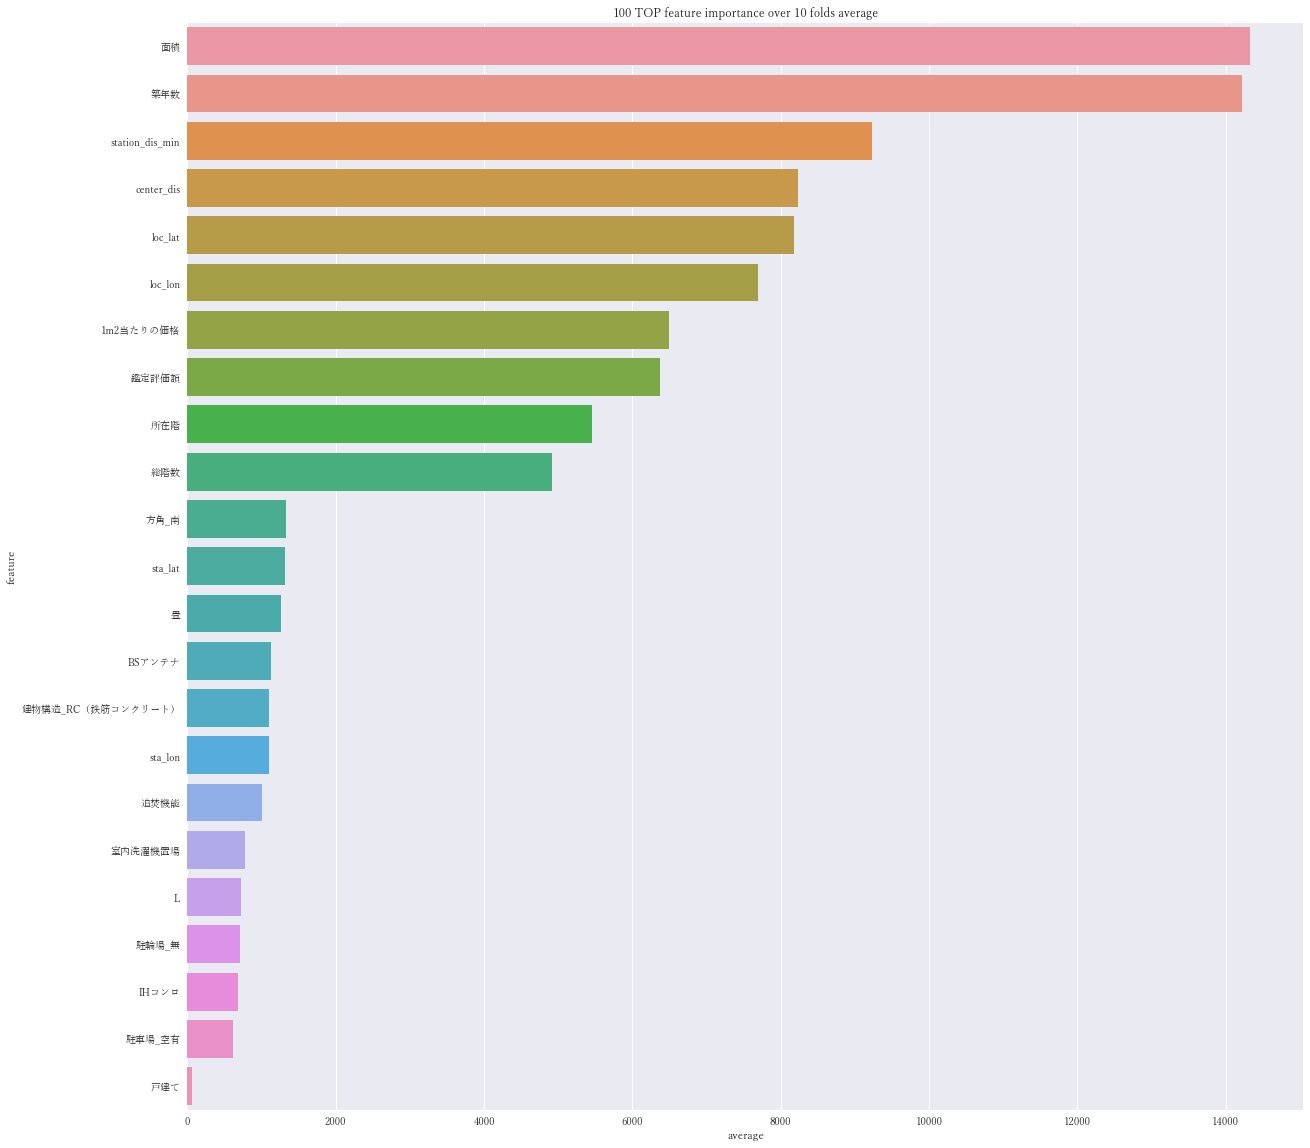

In [46]:
import lightgbm as lgb
from sklearn.model_selection import KFold, train_test_split
from time import time
import datetime

params = {
    'num_iterations': 15000,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mae',
    'max_depth': -1,
    'colsample_bytree': 1.0,
    'colsample_bylevel': 0.3,
    'gamma': 0,
    'lambda': 1,
    'eta': 0.1,
    'min_child_weight': 1,
    'verbose': 1,
    'random_state': 0,
    'early_stopping_round': 50

    }

kf = KFold(n_splits=n_splits, random_state=SEED)


rmses = list()
feature_importances = pd.DataFrame()
feature_importances['feature'] = X_train.columns
predictions = pd.DataFrame({'id':list(test.id.values)})
oof = pd.DataFrame({'id':list(train.id.values),'y_train':list(y_train.values)})
training_start_time = time()

for fold, (trn_idx, val_idx) in enumerate(kf.split(X_train, y_train_log)):
    start_time = time()
    print('Training on fold {}'.format(fold + 1))
    
    tr_x, tr_y = X_train.iloc[trn_idx], y_train_log.iloc[trn_idx]
    vl_x, vl_y = X_train.iloc[val_idx], y_train_log.iloc[val_idx]
    print(len(tr_x), len(vl_y))
    
    tr_data = lgb.Dataset(tr_x, label=tr_y)
    vl_data = lgb.Dataset(vl_x, label=vl_y)
    clf = lgb.train(params, tr_data, 5000, valid_sets = [tr_data, vl_data], verbose_eval=500, early_stopping_rounds=20)
    oof.loc[val_idx,'oof'] = np.expm1(clf.predict(vl_x, num_iteration=clf.best_iteration))
    
    ## アンサンブル
    print('start predict')
    pred = clf.predict(X_test)
    predictions['pred'+str(fold)] = np.expm1(pred)
 
    feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance()
    rmses.append(clf.best_score['valid_1']['l1'])
    
    del tr_x, tr_y, vl_x, vl_y, tr_data, vl_data
    gc.collect()
    
    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))
print('-' * 30)
print('Training has finished.')
print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
print('Mean RMSE:', np.mean(rmses))
print('-' * 30)

feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for kf in range(kf.n_splits)]].mean(axis=1)

plt.figure(figsize=(20, 20))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(100), x='average', y='feature');
plt.title('100 TOP feature importance over {} folds average'.format(kf.n_splits));

In [47]:
feature_importances.sort_values(by='average',ascending=False)

,feature,fold_1,fold_2,fold_3,fold_4,fold_5,fold_6,fold_7,fold_8,fold_9,fold_10,average
0,面積,16750,8753,13865,18776,12743,13443,11136,7860,9530,14333,14333.0
1,築年数,15737,8960,13519,17850,12463,12752,11345,8390,9791,14218,14218.0
2,station_dis_min,10604,5644,8967,11933,8202,8558,7184,5257,6105,9232,9232.0
5,center_dis,9493,5166,7797,10614,7265,7727,6646,5004,5760,8234,8234.0
3,loc_lat,9148,5358,8046,10057,7187,7634,6470,4824,5468,8180,8180.0
4,loc_lon,8721,4980,7375,9840,7124,7266,6183,4767,5477,7692,7692.0
22,1m2当たりの価格,7243,4034,6147,8135,5750,5897,4903,3911,4352,6494,6494.0
21,鑑定評価額,7269,4190,6182,8429,5975,6014,4999,3746,4439,6372,6372.0
8,所在階,6473,3264,5312,7585,4799,5003,4108,2970,3596,5461,5461.0
6,総階数,5646,3290,4755,6199,4465,4491,3855,2958,3387,4917,4917.0


RMSE :  15919.205819334275
R^2 :  0.9485446035634229


Text(0,0.5,'correct')

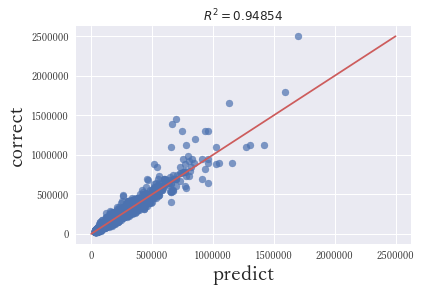

In [48]:
## データ拡張した時
oof['oof'] = oof.id.map(oof.groupby('id').oof.mean())
oof = oof.drop_duplicates(subset='id')

#validationのずれを確認する
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

print('RMSE : ',np.sqrt(mean_squared_error(oof['oof'], oof['y_train'])))
print('R^2 : ',r2_score(oof['oof'], oof['y_train']))
plt.figure()
plt.scatter(oof['oof'], oof['y_train'], alpha=0.7)
plt.title("$R^2 = {:<.5}$".format(r2_score(oof['oof'], oof['y_train'])))
x = np.linspace(0, 2500000, 100)
plt.plot(x, x, c="indianred")
plt.xlabel('predict',size=20)
plt.ylabel('correct',size=20)

### 提出

In [49]:
## バリデーションの平均
predictions['mean'] = predictions[['pred0','pred1','pred2','pred3','pred4','pred5','pred6','pred7','pred8','pred9']].mean(axis=1)
predictions['median'] = predictions[['pred0','pred1','pred2','pred3','pred4','pred5','pred6','pred7','pred8','pred9']].median(axis=1)
predictions.head()

,id,pred0,pred1,pred2,pred3,pred4,pred5,pred6,pred7,pred8,pred9,mean,median
0,31471,123294.226212,131532.639446,121288.422831,117985.297951,130879.649437,111789.744486,123239.689302,120732.825740,124793.126193,134694.681831,124023.030343,123266.957757
1,31471,122953.253422,130886.878869,121908.747357,118387.475104,130920.159671,110837.467030,122638.838989,119392.616884,124751.790494,134379.265046,123705.649287,122796.046205
2,31471,122020.177076,129967.377486,120765.846672,116405.558101,130738.335730,112374.041385,124657.673973,121734.371760,124597.617453,134426.426471,123768.742611,123308.897265
3,31472,115665.579838,114706.680847,112962.459273,115922.449187,114922.117541,116863.410855,115539.662388,115378.923853,115475.127748,115019.339220,115245.575075,115427.025800
4,31472,116327.823699,115203.152070,113831.297105,116812.563026,115895.812380,117096.465805,116230.927350,116921.434079,115822.922520,115412.267778,115955.466581,116063.369865


In [50]:
## idごとの平均
predictions['mean'] = predictions.id.map(predictions.groupby('id')['mean'].mean())
predictions = predictions.drop_duplicates(subset='id').reset_index()
predictions.head()

,index,id,pred0,pred1,pred2,pred3,pred4,pred5,pred6,pred7,pred8,pred9,mean,median
0,0,31471,123294.226212,131532.639446,121288.422831,117985.297951,130879.649437,111789.744486,123239.689302,120732.825740,124793.126193,134694.681831,123832.474080,123266.957757
1,3,31472,115665.579838,114706.680847,112962.459273,115922.449187,114922.117541,116863.410855,115539.662388,115378.923853,115475.127748,115019.339220,115600.520828,115427.025800
2,5,31473,75873.160651,74796.332195,75339.507862,77528.695307,73891.341659,75912.171699,77968.759740,74605.588096,75362.688583,72312.774547,75451.278558,75351.098222
3,8,31474,57823.065650,59030.361332,59173.218038,63263.451984,59159.863874,57118.466254,60593.872116,60010.870989,55355.481601,58176.737239,59044.208962,59095.112603
4,11,31475,101958.552793,102995.510008,97554.056148,116108.403860,95998.774817,93967.830764,94677.993774,98552.767748,100642.884159,104197.797508,102102.573503,99597.825953


In [54]:
submit = pd.read_csv('../../submit/sample_submit.csv',header=None)
submit = submit.rename(columns={0:'id',1:'target'})
submit['target'] = predictions['mean']
# 提出
submit.to_csv('../../submit/submit29.csv', index=None, header=None)
submit.head()

,id,target
0,31471,123832.474080
1,31472,115600.520828
2,31473,75451.278558
3,31474,59044.208962
4,31475,102102.573503



 mu = 117677.08 and sigma = 70280.07



Text(0.5,1,'SalePrice distribution')

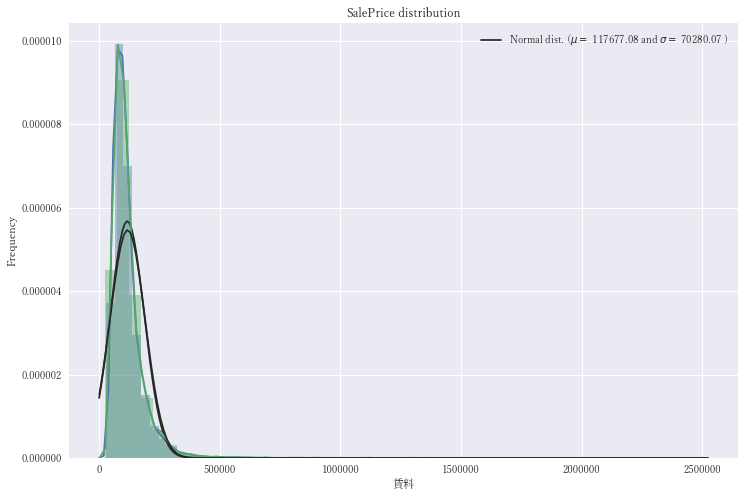

In [55]:
plt.figure(figsize=(12,8))
g = sns.distplot(submit['target'],fit=norm)
g = sns.distplot(train['賃料'],fit=norm)
(mu,sigma) = norm.fit(submit['target'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
g.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
g.set_ylabel('Frequency')
g.set_title('SalePrice distribution')

In [56]:
submit['target'].describe().reset_index()

,index,target
0,count,3.126200e+04
1,mean,1.176771e+05
2,std,7.028120e+04
3,min,2.782039e+04
4,25%,7.635644e+04
5,50%,1.014219e+05
6,75%,1.360124e+05
7,max,1.883495e+06


In [57]:
submit['target'].describe().reset_index()

,index,target
0,count,3.126200e+04
1,mean,1.176771e+05
2,std,7.028120e+04
3,min,2.782039e+04
4,25%,7.635644e+04
5,50%,1.014219e+05
6,75%,1.360124e+05
7,max,1.883495e+06
